<a href="https://colab.research.google.com/github/ssaran2014/tensorflow/blob/master/cifar10v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image classification on the cifar10 dataset. Tensorflow dataset is here: https://www.tensorflow.org/datasets/catalog/cifar10

Dataset homepage is here: https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import tensorflow as tf
import tensorflow_datasets.public_api as tfds
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
#import keras

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image

import pathlib
import os

from tensorflow.keras.datasets import cifar10


In [2]:
print(tf.__version__)
#expecting 2.2 or greater

2.3.0


In [4]:
def load_data():
  (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
  return (train_images, train_labels), (test_images, test_labels)

(train_images, train_labels), (test_images, test_labels) = load_data()

<Figure size 432x288 with 0 Axes>

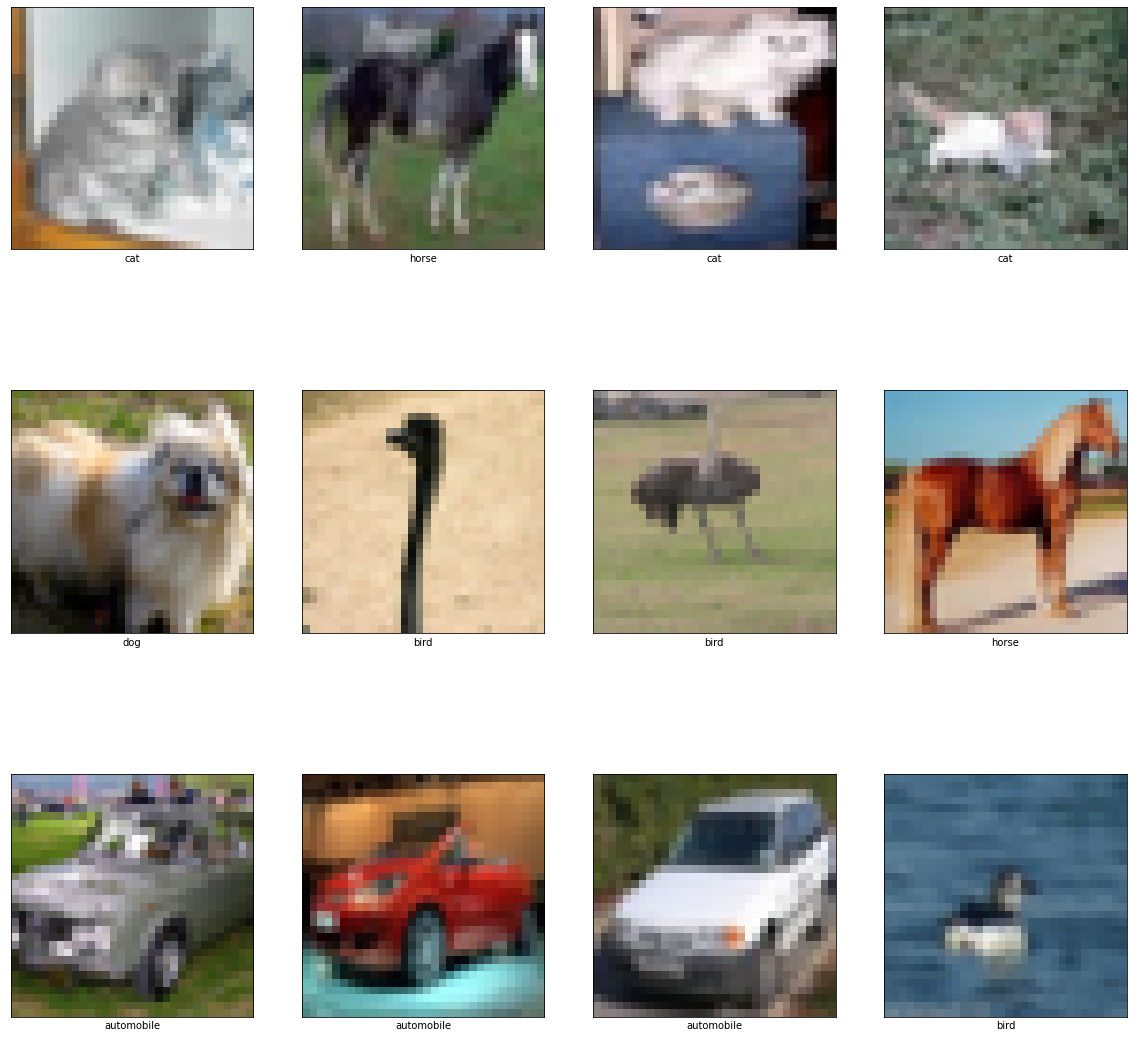

In [5]:
def visualize_dataset(train_images, train_labels):
  %matplotlib inline

  #set label names
  label_name = {
      0 : 'airplane',
      1 : 'automobile',
      2 : 'bird',
      3 : 'cat',
      4 : 'deer',
      5 : 'dog',
      6 : 'frog',
      7 : 'horse',
      8 : 'ship',
      9 : 'truck'}

  nrows, ncols = 3, 4

  fig = plt.gcf()
  plt.subplots(nrows = 3, ncols = 4, figsize=(20,20))

  counter = 1 #using counter to position the image on the grid
  for i in range(36, 48):
    next_element_image = train_images[i]
    next_element_label = train_labels[i].item()
    image, label = next_element_image, label_name[next_element_label]#+'('+str(next_element_label+')'
    sp = plt.subplot(3, 4, counter)
    plt.rcParams["axes.grid"] = False
    plt.xlabel(label)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    counter += 1

visualize_dataset(train_images, train_labels)

In [6]:
def one_hot_encoding(train_labels, test_labels):
  #num_classes = 10
  train_labels = to_categorical(train_labels)
  test_labels = to_categorical(test_labels)
  return train_labels, test_labels

train_labels, test_labels = one_hot_encoding(train_labels, test_labels)

In [7]:
def prepare_images(train_images, test_images):
  #convert images to floating point and normalize arrays between 0 and 1
  train_images = train_images.astype('float32')/255.0
  test_images = test_images.astype('float32')/255.0
  return train_images, test_images

train_images, test_images = prepare_images(train_images, test_images)

In [8]:
data_augmentation = ImageDataGenerator(
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  horizontal_flip = True
)

train_with_aug = data_augmentation.flow(train_images, train_labels, batch_size=64)

In [9]:
#defining a keras model
def define_model():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding = 'same', input_shape = (32,32,3)),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding = 'same'),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.MaxPool2D(2,2),
                                      tf.keras.layers.Dropout(0.2),
                                      tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding = 'same'),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding = 'same'),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.MaxPool2D(2,2),
                                      tf.keras.layers.Dropout(0.2),
                                      tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding = 'same'),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding = 'same'),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.MaxPool2D(2,2),
                                      tf.keras.layers.Dropout(0.4),
                                      tf.keras.layers.Flatten(),
                                      tf.keras.layers.Dense(128, activation = 'relu', kernel_initializer='he_uniform'),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.Dropout(0.5),
                                      tf.keras.layers.Dense(10, activation = 'softmax')
  ])

  model.compile(
      #optimizer = Adam(),
      optimizer = SGD(lr=0.001, momentum=0.9),
      loss=CategoricalCrossentropy(from_logits=True),
      metrics = ['accuracy']
  )

  model.summary()
  return model

model = define_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [10]:
def history(train_images, train_labels, test_images, test_labels, model):

  batch_size = 64
  epochs = 200

  callback = EarlyStopping(monitor = 'loss', patience = 5)

  history = model.fit(
      #train_images, train_labels, #deactivated to enable image augmentation
      train_with_aug,
      validation_data = (test_images, test_labels),
      batch_size = 64,
      #steps_per_epoch=int(len(train_images)/batch_size),
      epochs=epochs,
      callbacks = [callback],
      verbose = 1
  )

  _, acc = model.evaluate(test_images, test_labels)
  print('Accuracy: {:.2%}'.format(acc))

  return history

history = history(train_images, train_labels, test_images, test_labels, model)

Epoch 1/200
782/782 [==============================] - 38s 49ms/step - loss: 2.2295 - accuracy: 0.2130 - val_loss: 2.1117 - val_accuracy: 0.3571
Epoch 2/200
782/782 [==============================] - 39s 49ms/step - loss: 2.1256 - accuracy: 0.3318 - val_loss: 2.0520 - val_accuracy: 0.4085
Epoch 3/200
782/782 [==============================] - 38s 49ms/step - loss: 2.0853 - accuracy: 0.3743 - val_loss: 2.0203 - val_accuracy: 0.4382
Epoch 4/200
782/782 [==============================] - 38s 49ms/step - loss: 2.0592 - accuracy: 0.4003 - val_loss: 2.0065 - val_accuracy: 0.4508
Epoch 5/200
782/782 [==============================] - 38s 49ms/step - loss: 2.0396 - accuracy: 0.4198 - val_loss: 1.9857 - val_accuracy: 0.4739
Epoch 6/200
782/782 [==============================] - 38s 48ms/step - loss: 2.0237 - accuracy: 0.4361 - val_loss: 1.9748 - val_accuracy: 0.4840
Epoch 7/200
782/782 [==============================] - 39s 50ms/step - loss: 2.0053 - accuracy: 0.4559 - val_loss: 1.9953 - val_ac

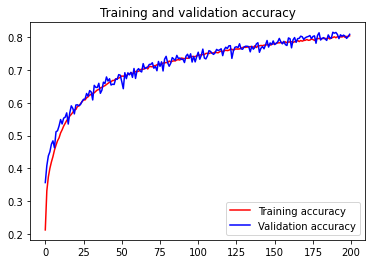

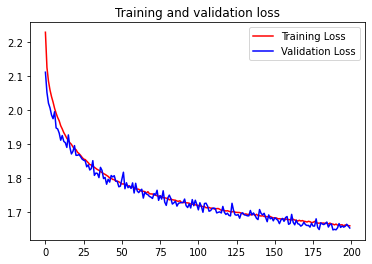

In [11]:
# Plot the chart for accuracy and loss on both training and validation
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

plot_history(history)

In [ ]:
def full_sequence():
  #load data
  (train_images, train_labels), (test_images, test_labels) = load_data()

  #visualize data
  visualize_dataset(train_images, train_labels)

  #prepare y labels with one hot encoding
  train_labels, test_labels = one_hot_encoding(train_labels, test_labels)

  #rescale images
  train_images, test_images = prepare_images(train_images, test_images)

  #define model
  model = define_model()

  #early stopping
  callback = EarlyStopping(monitor = 'loss', patience = 5)

  history = model.fit(
      #train_images, train_labels, #deactivated to enable image augmentation
      train_with_aug,
      validation_data = (test_images, test_labels),
      batch_size = 64,
      #steps_per_epoch=int(len(train_images)/batch_size),
      epochs=epochs,
      callbacks = [callback],
      verbose = 1
  )

  _, acc = model.evaluate(test_images, test_labels)
  print('Accurary: {:.2%}'.format(acc))

This model is showing 80.8% accuracy. The model is still improving accuracy with additional epochs. So increasing the number of epochs could increase accuracy.

State of the art results achieve 99%+ accuracy on this dataset. See https://arxiv.org/pdf/1912.11370.pdf
